In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy.special as sp

from skimage import io

from scipy.ndimage import gaussian_filter
from scipy import interpolate

from numpy.fft import fft2, fftshift, ifft2


# Startup

In [ ]:
# Load the PSF
experimental_PSF = io.imread('/Volumes/SanDisk/MakingCustomPSF/PSF.tif')

# Load the Experimental data
img = plt.imread("/Volumes/SanDisk/MakingCustomPSF/Im0.tif")


In [4]:
# Parameters of imaging
lambda_ = 520.0    				    	# illumination wavelength [nm]
n_ref = 1.333					    # refractive index of medium
sliceSpacing = 5000 					# in object space [nm]


# Design parameters of the FLFM system
Obj_NA = 0.8
pix_size = 6.5 # um/pixel
F_fourier = 200 #Focal length of Fourier lens
F_tubelens = 300 #Focal length of tube lens
F_MLA = 30 #Focal length of microlens array [mm]
F_obj = (200/16) #Focal length of objective
d_MLA = 1.3 #Aperature of the microlens array [mm]
d_Cam = 13.2 #Length of camera chip [mm]

In [ ]:
# Defining all relevant functions




def DetectLine(vol_slice, ymin, xmin, PSF_depth):

    vol_bw_slice=np.zeros_like(vol_slice)

    z_center = np.linspace(0, PSF_depth-1, PSF_depth)
    x_center = np.zeros_like(z_center)
    y_center = np.zeros_like(z_center)


    for zz in range(0, PSF_depth):

        im_slice = vol_slice[zz, :, :]

        blur = gaussian_filter(im_slice, 3)

        xs, ys = np.where(blur==np.max(blur))

        x_center[zz] = xs[0]
        y_center[zz] = ys[0]


    f_x = interpolate.interp1d(z_center, y_center+ymin)
    f_y = interpolate.interp1d(z_center, x_center+xmin)

    return f_x, f_y


# Richardson-Lucy 3D-to-2D deconvolution
def RL_3Ddeconv(img, FFT_PSF, rec_vol, FFT_PSF_inv_norm, n_iter):

    for it in tqdm(range(n_iter)):

        proj_im = np.zeros((np.shape(rec_vol)[1],np.shape(rec_vol)[2]), dtype=np.float32)

        for s in range(len(FFT_PSF)):

            conv_result = np.real(fftshift(ifft2(fft2(rec_vol[s, :, :]) * FFT_PSF[s, :, :])))

            proj_im += conv_result

        im_error = img / proj_im
        im_error[proj_im == 0] = 0
        im_error[im_error < 0] = 0

        FFT_im_error = fft2(im_error)

        rec_vol_err =  np.zeros_like(FFT_PSF_inv_norm)

        for s in range(len(FFT_PSF_inv_norm)):
            rec_vol_err[s, :, :] = np.real(fftshift(ifft2(FFT_PSF_inv_norm[s, :, :] * FFT_im_error)))

        rec_vol = np.multiply(rec_vol,rec_vol_err)

    return rec_vol


def conv2(FFT_PSF_inv_norm, FFT_im_error):

    rec_vol_err =  np.zeros_like(FFT_PSF_inv_norm)

    for s in range(len(FFT_PSF_inv_norm)):
            rec_vol_err[s, :, :] = np.real(fftshift(ifft2(FFT_PSF_inv_norm[s, :, :] * FFT_im_error)))

    return rec_vol_err

# Code For Microlens PSF Generation

### This will all be eliminated when we have automated detection

In [6]:

def GetCoordinates(calib_file):
    p = 0
    x = True
    c = []

    with open(calib_file, 'r') as file:
        av_radius = float(file.readline())
        for line in file:
            c.append([int(line.strip().split('\t')[0]), int(line.strip().split('\t')[1])]) #Return this as centers
        
    lenses_in_row = [3, 3, 3]

    N_rows = len(lenses_in_row)

    mid_row = int((N_rows-1)/2)
    center_lens_num = np.sum(lenses_in_row[:mid_row]) + int((lenses_in_row[mid_row]-1)/2)

    pts = np.array(c)
    pts_sort = pts[np.argsort(pts[:, 1]), :]


    av_pitch = 0
    N = 0

    # all the next-door points
    for ii in range(0, len(lenses_in_row)):
        for jj in range(lenses_in_row[ii]-1):
            lens1 = int(np.sum(lenses_in_row[:ii]) + jj)
            lens2 = int(np.sum(lenses_in_row[:ii]) + jj+1)
            d = np.sqrt((pts_sort[lens1, 0] -pts_sort[lens2, 0])**2 + (pts_sort[lens1, 1] -pts_sort[lens2, 1])**2)
            av_pitch += d
            N +=1

#all the frist points in each row

    for ii in range(np.min(lenses_in_row)):
        for jj in range(N_rows-1):
            lens1 = int(np.sum(lenses_in_row[:jj]) + ii)
            lens2 = int(np.sum(lenses_in_row[:jj+1]) + ii)
            d = np.sqrt((pts_sort[lens1, 0] -pts_sort[lens2, 0])**2 + (pts_sort[lens1, 1] -pts_sort[lens2, 1])**2)
            av_pitch += d
            N += 1

    av_pitch /= N if N != 0 else 1

    norm_distances = []
    for i in range(len(c)):
        d = [(c[i][0] - c[len(c) // 2][0]) / av_pitch, (c[i][1] - c[len(c) // 2][1]) / av_pitch]
        norm_distances.append(d)
        
    return av_radius, pts_sort, norm_distances, int(np.round(av_pitch)), center_lens_num

In [7]:

calib_file = "/Volumes/SanDisk/MakingCustomPSF/Calib.txt"

p = 0
x = True
c = []

with open(calib_file, 'r') as file:
    av_radius = float(file.readline())
    for line in file:
        c.append([int(line.strip().split('\t')[0]), int(line.strip().split('\t')[1])]) #return this as centers
        
lenses_in_row = [3, 3, 3]

N_rows = len(lenses_in_row)

mid_row = int((N_rows-1)/2)
center_lens_num = np.sum(lenses_in_row[:mid_row]) + int((lenses_in_row[mid_row]-1)/2)

pts = np.array(c)
pts_sort = pts[np.argsort(pts[:, 1]), :]


av_pitch = 0
N = 0

# all the next-door points
for ii in range(0, len(lenses_in_row)):
    for jj in range(lenses_in_row[ii]-1):
        lens1 = int(np.sum(lenses_in_row[:ii]) + jj)
        lens2 = int(np.sum(lenses_in_row[:ii]) + jj+1)
        d = np.sqrt((pts_sort[lens1, 0] -pts_sort[lens2, 0])**2 + (pts_sort[lens1, 1] -pts_sort[lens2, 1])**2)
        av_pitch += d
        N +=1

#all the frist points in each row

for ii in range(np.min(lenses_in_row)):
    for jj in range(N_rows-1):
        lens1 = int(np.sum(lenses_in_row[:jj]) + ii)
        lens2 = int(np.sum(lenses_in_row[:jj+1]) + ii)
        d = np.sqrt((pts_sort[lens1, 0] -pts_sort[lens2, 0])**2 + (pts_sort[lens1, 1] -pts_sort[lens2, 1])**2)
        av_pitch += d
        N += 1

av_pitch /= N if N != 0 else 1

norm_distances = []
for i in range(len(c)):
    d = [(c[i][0] - c[len(c) // 2][0]) / av_pitch, (c[i][1] - c[len(c) // 2][1]) / av_pitch]
    norm_distances.append(d)




row = img.shape[0] - 1  # Row to delete
col = img.shape[1] - 1  # Column to delete
rect = (0, 0, col, row)
img = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]  # Crop the image

# LF PSF creation
av_radius, centers, norm_distances, av_pitch, center_lens_num = GetCoordinates(calib_file)


## Add functionality to detect the circles!

# Make the Airy disk PSF

### This is all from the Valencia code. 

In [8]:
# Derived parameters to make Airy PSF

M_total = (F_MLA*F_tubelens)/(F_fourier*F_obj)
PSF_depth = experimental_PSF.shape[0] 			# number of reconstruction planes
pixelSpacing =  pix_size*1000/M_total	# in object space [nm]
N = d_Cam/d_MLA #Number of microlenses in the aperature stop
NA_eff = Obj_NA/N							# effective NA
d_Airy = 2*int((0.61*lambda_/NA_eff*M_total)/pixelSpacing) #diameter of airy disk [pixels]

In [9]:

PSF_width = 4*d_Airy								# width of the calculated PSF [pixels] 
PSF_height = 4*d_Airy								# height of the calculated PSF [pixels]

PSF_mat = np.zeros((PSF_depth, PSF_width, PSF_height))

stepsPerCycle = 10 

x_c = PSF_width // 2
y_c = PSF_height // 2
z_c = PSF_depth // 2


# Microlens PSF creation
max_radius = 2 + int(np.sqrt(x_c**2 + y_c**2))
integral = np.zeros(max_radius, dtype=float)
upper_limit = np.tan(np.arcsin(NA_eff / n_ref))
wave_num = 2 * np.pi * n_ref / lambda_

for k in tqdm(range(PSF_depth)):
	kz = wave_num * (k - z_c) * sliceSpacing
	pixel_values = np.zeros((PSF_width  * PSF_height), dtype=float)
	for r in range(0, max_radius):
		kr = wave_num * r * pixelSpacing
		num_cycles = max(int(kr * upper_limit / 3), int(abs(kz) * 0.06 * upper_limit)) + 1
		nStep = 2 * stepsPerCycle * num_cycles
		m = nStep // 2
		step = upper_limit / nStep
		sum_real = 0
		sum_im = 0
		for j in range(1, m + 1):
			# Even argument: 2 * j * step (only for j < m)
			if j < m:
				u1 = 2 * j * step
				bessel1 = sp.j0(kr * u1 / np.sqrt(1 + u1**2))
				angle1 = kz / np.sqrt(1 + u1**2)
				sum_real += np.cos(angle1) * u1 * bessel1
				sum_im += np.sin(angle1) * u1 * bessel1

    		# Odd argument: (2 * j - 1) * step (for all j)
			u2 = (2 * j - 1) * step
			bessel2 = sp.j0(kr * u2 / np.sqrt(1 + u2**2))
			angle2 = kz / np.sqrt(1 + u2**2)
			sum_real += 2 * np.cos(angle2) * u2 * bessel2
			sum_im += 2 * np.sin(angle2) * u2 * bessel2

		#f(b)
		bessel = sp.j0(kr * upper_limit / np.sqrt(1 + upper_limit**2))
		angle = kz / np.sqrt(1 + upper_limit**2)
		sum_real += 0.5*np.cos(angle) * upper_limit * bessel
		sum_im += 0.5*np.sin(angle) * upper_limit * bessel

		integral[r] = step**2 * (sum_real**2 + sum_im**2 ) / 9
		
	for yy in range(0, PSF_height):
		for xx in range(0, PSF_width): 
			rPixels = np.sqrt((xx - x_c)**2 + (yy - y_c)**2)
			pixel_values[xx + PSF_width * yy] = np.interp(rPixels,np.linspace(0, max_radius-1, len(integral)), integral)

	PSF_mat[k, :, :] = pixel_values.reshape((PSF_width, PSF_height))


    


100%|██████████| 41/41 [00:06<00:00,  6.48it/s]


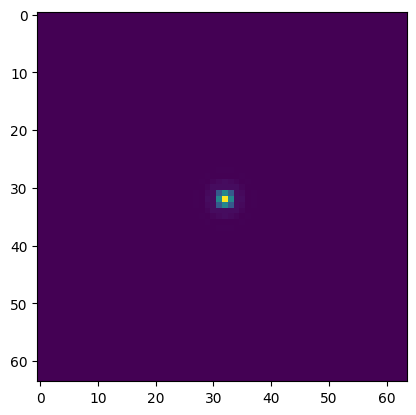

In [10]:
plt.imshow(PSF_mat[10, :, :])

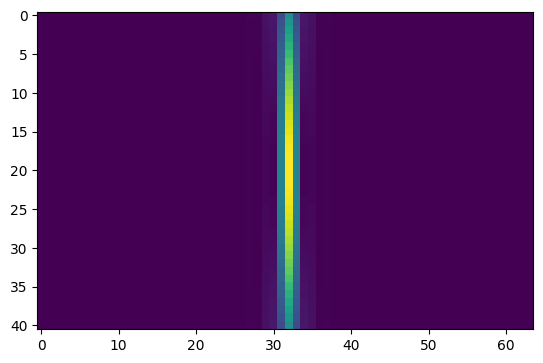

In [11]:
plt.imshow(PSF_mat[:, 2*d_Airy, :])


In [ ]:
# Realign the simulated PSF to match the experimnetnal PSF

Corrected_Airy_psf = np.zeros((PSF_depth,img.shape[0],img.shape[1]))

for cc in range(len(centers)):

    x_range = (centers[cc][0]- int(np.floor(av_pitch / 2 )) , centers[cc][0]  + int(np.floor(av_pitch / 2  ))+1)
    y_range = (centers[cc][1]  - int(np.floor(av_pitch / 2 )), centers[cc][1]  + int(np.floor(av_pitch / 2 )) + 1)
        

    x_cent = int((x_range[1] + x_range[0])/2)
    y_cent = int((y_range[1] + y_range[0])/2)

    xmin =int(x_cent-av_pitch/2)
    xmax =int(x_cent+av_pitch/2)

    ymin =int(y_cent-av_pitch/2)
    ymax =int(y_cent+av_pitch/2)


    vol_slice = experimental_PSF[:,ymin:ymax, xmin:xmax]

    f_x, f_y = DetectLine(vol_slice,  xmin, ymin, PSF_depth)

    for ii in range(0,PSF_depth):

        x_cent = f_x(ii)
        y_cent = f_y(ii)

        xmin =int(x_cent-PSF_width/2)
        xmax =int(x_cent+PSF_width/2)

        ymin =int(y_cent-PSF_height/2)
        ymax =int(y_cent+PSF_height/2)
    
        Corrected_Airy_psf[ii, ymin:ymax, xmin:xmax] = PSF_mat[ii, :, :]





## Make the hybrid-PSF just using the gaussian disk

### The PSF can be approximated as a Gaussian, with a width equal to the width of the central lobe of the airy disk. That is:

$\omega_0 \approx 0.84*\lambda*f \#$ 

where 

$f \# = 1/2 \sqrt{(n/NA)^2 - 1}$

so that,

$\omega_0 \approx 0.42*\lambda*\sqrt{(n/NA)^2 - 1}$

In [16]:
gauss_stdev = (0.42*lambda_*np.sqrt((n_ref/NA_eff)**2 -1))/pixelSpacing #Standard devition of Gaussian approximating Airy disk [pix]


2.042925791396164

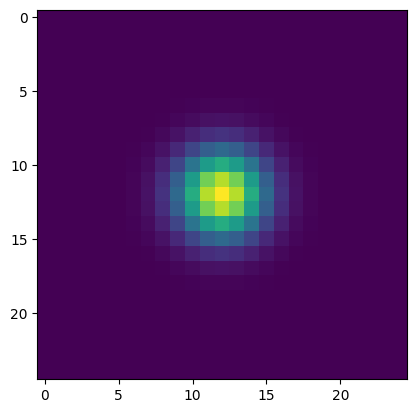

In [17]:


gauss_sz = 2*int(6*gauss_stdev) + 1 # plot out to 5*\sigma


gauss = np.zeros((gauss_sz, gauss_sz))

gauss[int((gauss_sz-1)/2), int((gauss_sz-1)/2)]=1

gauss = gaussian_filter(gauss, gauss_stdev)

plt.imshow(gauss)

In [ ]:

Gauss_psf=np.zeros((PSF_depth,img.shape[0],img.shape[1]))

for cc in range(len(centers)):

    x_range = (centers[cc][0]- int(np.floor(av_pitch / 2 )) , centers[cc][0]  + int(np.floor(av_pitch / 2  ))+1)
    y_range = (centers[cc][1]  - int(np.floor(av_pitch / 2 )), centers[cc][1]  + int(np.floor(av_pitch / 2 )) + 1)
        
    x_cent = int((x_range[1] + x_range[0])/2)
    y_cent = int((y_range[1] + y_range[0])/2)

    xmin =int(x_cent-av_pitch/2)
    xmax =int(x_cent+av_pitch/2)

    ymin =int(y_cent-av_pitch/2)
    ymax =int(y_cent+av_pitch/2)


    vol_slice = experimental_PSF[:,ymin:ymax, xmin:xmax]

    f_x, f_y = DetectLine(vol_slice,  xmin, ymin, PSF_depth)

    for ii in range(0,PSF_depth):

        x_cent = f_x(ii)
        y_cent = f_y(ii)

        xmin =int(x_cent-(int((gauss_sz-1)/2)+1))
        xmax =int(x_cent+int((gauss_sz-1)/2))

        ymin =int(y_cent-(int((gauss_sz-1)/2)+1))
        ymax =int(y_cent+int((gauss_sz-1)/2))
    
        Gauss_psf[ii, ymin:ymax, xmin:xmax] = gauss

# Run deconvolution

In [25]:
#PSF_to_use = Gauss_psf
PSF_to_use = Corrected_Airy_psf

PSF_to_use /= np.sum(Corrected_Airy_psf)

LF_PSF_mat_inv = np.zeros(np.shape(PSF_to_use))
vals_sum = 0.0
for s in range(PSF_depth):
    aux = np.flip(PSF_to_use[s, :, :], axis=(-2, -1))
    LF_PSF_mat_inv[s, :, :] = aux
    vals_sum += np.sum(aux)

LF_PSF_mat_inv_norm = LF_PSF_mat_inv/vals_sum

FFT_PSF_inv_norm = fft2(LF_PSF_mat_inv_norm)


img = img.astype(np.float32)
vol_0 = np.ones((PSF_depth,img.shape[0],img.shape[1]))
FFT_PSF = fft2(PSF_to_use)





In [26]:
reconst_volume = RL_3Ddeconv(img, FFT_PSF, vol_0, FFT_PSF_inv_norm, 10)

100%|██████████| 10/10 [06:41<00:00, 40.11s/it]
